# Data Preprocessing

Data source: https://www.kaggle.com/kmader/rsna-bone-age

Problem: The images have all different sizes and the contrast is not very well in some images. 

Solution: Use skimage to preprocess and resize the image.

## Setup

In [11]:
from glob import iglob
import skimage.io as io
from skimage import img_as_float
from skimage import exposure
import skimage.filters as filters
from skimage.util import img_as_ubyte
from skimage.transform import resize
from skimage.morphology import reconstruction
from scipy.ndimage import gaussian_filter
#from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import random

In [12]:
path_train_orig = "boneage-training-dataset/boneage-training-dataset/"
path_train_preprocessed = "boneage-training-dataset/train_preprocessed/"

path_test_orig = "boneage-test-dataset/boneage-test-dataset/"
path_test_orig = "boneage-test-dataset/test_preprocessed/"

## Read Image ids and plot some random sample 

In [13]:
# read image ids
id = []
for path in iglob(path_train_orig + '*.png'):
    path_split= path.split("/")
    name = path_split[-1].split('.')[0]
    id.append(int(name))

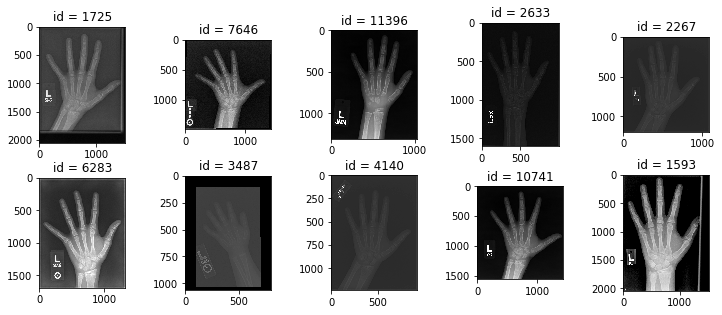

In [14]:
# select randomly 10 images from id list and plot
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
n = 10
id_select = []
for i in range(n):
    rand_id = random.choice(id)
    id_select.append(rand_id)
    img = io.imread(path_train_orig + str(rand_id) + '.png')
    if i<n/2:
        axes[0,i].imshow(img, cmap=plt.cm.gray)
        axes[0,i].set_title("id = " + str(rand_id))
    else:
        axes[1,int(i-n/2)].imshow(img, cmap=plt.cm.gray)
        axes[1,int(i-n/2)].set_title("id = " + str(rand_id))
        

## Make all images shapes to squares

Black Margins are added, if necessary, so that all images have the shape of suares.

In [15]:
# function for making all images to squares
# pad 0s (add black background)

def square(img):    
    diff = img.shape[0] - img.shape[1]
    if diff%2==0:
        pad1=int(np.floor(np.abs(diff)/2))
        pad2=int(np.floor(np.abs(diff)/2))
    else:
        pad1=int(np.floor(np.abs(diff)/2))
        pad2=int(np.floor(np.abs(diff)/2))+1
    #test if image is square:
    if diff==0:
        return (img, img.shape[0])
    #horizontal length>vertical length -> pad half of the difference horizontally to each side
    if diff>0:
        img = np.pad(img, [(0,0), (pad1, pad2)], 'constant', constant_values=(0))
        return (img, img.shape[0])
    #horizontal length<vertical length -> pad half of the difference vertically to each side
    if diff<0:
        img = np.pad(img, [(pad1, pad2), (0,0)], 'constant', constant_values=(0))
        return (img, img.shape[0])
        
    

## Enhance Contrast and resize

The contrast is enhanced using gaussian filter and dilated images. Then resize images to 128x128 pixel and cut left and right margins. The left and right margins are mainly black due to making all images to squares. That is, we won't loose much information.

In [16]:
# function for enhancing the contrast
# code adapted from https://scipy-lectures.org/advanced/image_processing/
# Convert to float: Important for subtraction later which won't work with uint8

def contrast(img):
    img = img_as_ubyte(img/255)
    img = img_as_float(img)
    img = gaussian_filter(img, 1)
    h = 0.8
    seed = img - h
    #seed = np.copy(img)
    #seed[1:-1, 1:-1] = img.min()
    mask = img

    dilated = reconstruction(seed, mask, method='dilation')
    img_dil_adapteq = exposure.equalize_adapthist(img-dilated, clip_limit=0.03)

    return (dilated, img_dil_adapteq)

In [17]:
# set pixels below and a certain threshold to black (0)
# set pixels with values above 250 to 0 (background: their are some white artefacts in some images)

def thres(img):
    img_threshold = filters.threshold_li(img)
    img_new = np.ones(img.shape[:2], dtype="float") 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i, j] < img_threshold) or ((img[i, j] > 250)):
                img_new[i,j] = 0
            else:
                img_new[i,j] = img[i,j]
    return img_new

In [18]:
# resize to 128x128
# cut the left and right margins, which are mainly black
def resize_img(img):
    img = resize(img, (128, 128))
    img = img[:, 14:115] 
    return img

## Plot the same sample after the preprocessing

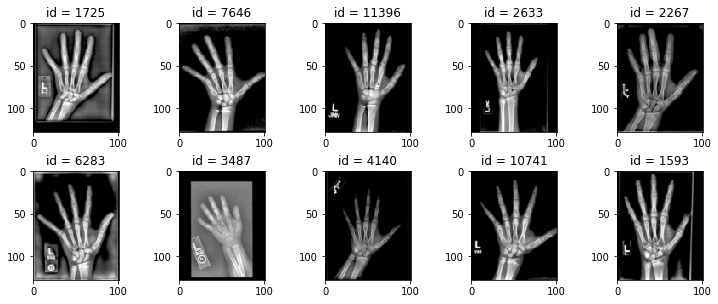

In [19]:
# plot after padding and enhancing the contrast
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
n = 10
for i in range(n):
    rand_id = id_select[i]
    img = io.imread(path_train_orig + str(rand_id) + '.png')
    # add black
    img_pad, img_pad_shape = square(img)
    #enhance contrast
    dil, adapt = contrast(img_pad)
    #threshold
    img = thres(adapt)
    #resize
    img = resize_img(img)
    if i<n/2:
        axes[0,i].imshow(img, cmap=plt.cm.gray)
        axes[0,i].set_title("id = " + str(rand_id))
    else:
        axes[1,int(i-n/2)].imshow(img, cmap=plt.cm.gray)
        axes[1,int(i-n/2)].set_title("id = " + str(rand_id))
        

## Preprocess all images and save the preproceesed images

In [20]:
# preprocess and save all preprocessed images
for path in iglob(path_train_orig + '9*.png'):
    img = io.imread(path)
    #add black
    img, img_shape = square(img)
    #enhance contrast
    dil, img = contrast(img)
    #threshold
    img = thres(img)
    #resize
    img = resize_img(img)
    #save
    name = path.split("/")
    img = img_as_ubyte(img)
    io.imsave(path_train_preprocessed + name[-1],img)